In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/Colab Notebooks/Thesis Project/

!pip install transformers
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Thesis Project
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.5 MB/s eta 0:00:00


In [2]:
print(torch.__version__)

2.0.1+cu118


In [3]:
# Load the data
df = pd.read_excel('0. All Datasets.xlsx')

df['label'] = df['label'].map({'Non Depressive': 0, 'Depressive': 1})
# Drop rows with any missing values
df = df.dropna(subset=['text', 'label'])
# drop rows that have identical values in all columns
df.drop_duplicates(inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31695 entries, 0 to 31698
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         31695 non-null  object
 1   label        31695 non-null  int64 
 2   word_length  31695 non-null  int64 
 3   text_length  31695 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.2+ MB
None


,text,label,word_length,text_length
0,আমি কি কখনও লক্ষ্য করা হবে? আমার জীবনের কি কোন...,1,2229,12117
1,আমি আশা করি না যে কেউ এই বিশৃঙ্খল জগাখিচুড়ি প...,1,2173,12230
2,আমি আর এটা সহ্য করতে পারছি না. আমি আর এটা সহ্য...,1,2100,9299
3,"আমি কয়েকদিন ধরে অনলাইনে পোস্ট করার কথা ভাবছি,...",1,2088,12273
4,আমি তুরস্কে বসবাসকারী একজন। আমার বয়স সম্ভবত আ...,1,1976,10966


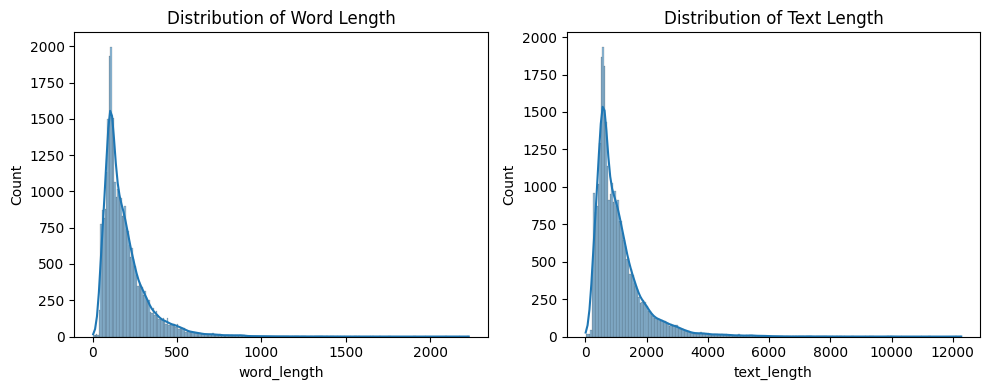

Word Length:
Mean: 190.77182520902352
Median: 150.0
Mode: 96
Skewness: 3.0461714860453317

Text Length:
Mean: 1100.240668875217
Median: 866.0
Mode: 555
Skewness: 2.984532525499655


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'df' with 'word_length' and 'text_length' columns

# Calculate mean, median, and mode of 'word_length' and 'text_length'
word_length_mean = df['word_length'].mean()
word_length_median = df['word_length'].median()
word_length_mode = df['word_length'].mode()[0]

text_length_mean = df['text_length'].mean()
text_length_median = df['text_length'].median()
text_length_mode = df['text_length'].mode()[0]

# Calculate skewness of 'word_length' and 'text_length'
word_length_skewness = df['word_length'].skew()
text_length_skewness = df['text_length'].skew()

# Visualize the distribution of 'word_length' and 'text_length' using histograms
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='word_length', kde=True)
plt.title('Distribution of Word Length')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='text_length', kde=True)
plt.title('Distribution of Text Length')

plt.tight_layout()
plt.show()

# Print the mean, median, mode, and skewness values
print('Word Length:')
print('Mean:', word_length_mean)
print('Median:', word_length_median)
print('Mode:', word_length_mode)
print('Skewness:', word_length_skewness)

print('\nText Length:')
print('Mean:', text_length_mean)
print('Median:', text_length_median)
print('Mode:', text_length_mode)
print('Skewness:', text_length_skewness)


In [5]:
# Calculate the length of each text
df['text_length'] = df['text'].str.len()

max_length = df['text_length'].max()
min_length = df['text_length'].min()

mean_length = df['text_length'].mean()
mode_length = df['text_length'].mode().values[0]



print("Max Length:", max_length)
print("Min Length:", min_length)

print("Mean Length:", mean_length)
print("Mode Length:", mode_length)


Max Length: 12273
Min Length: 14
Mean Length: 1100.3898406688752
Mode Length: 555


### Define Hyperparameter

In [9]:
# Define batch size
BATCH_SIZE = 16
LEARNING_RATE = 0.1

DROPOUT = 0.1

# Training loop
NUM_EPOCHS = 10

# Define number of folds for cross-validation
NUM_FOLDS = 5

# Momentum -> hyperparameter of Stochastic Gradient Descent (SGD) optimizer
MOMENTUM = 0.9


In [10]:
# Load the data
df = pd.read_excel('0. All Datasets.xlsx')

df['label'] = df['label'].map({'Non Depressive': 0, 'Depressive': 1})
# Drop rows with any missing values
df = df.dropna(subset=['text', 'label'])
# drop rows that have identical values in all columns
df.drop_duplicates(inplace=True)

# Assuming your DataFrame is named 'df'
columns_to_drop = [col for col in df.columns if col not in ['text', 'label']]
df.drop(columns=columns_to_drop, inplace=True)

print(df.info())

label_counts = df['label'].value_counts()
print("Label Details:")
print(label_counts)

df.sample(n=10)  # Change the value of 'n' to the desired number of random samples

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31695 entries, 0 to 31698
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    31695 non-null  object
 1   label   31695 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 742.9+ KB
None
Label Details:
0    16719
1    14976
Name: label, dtype: int64


,text,label
29482,আমি অনুসন্ধান ফাংশন চেষ্টা করেছি কিন্তু বেশিরভ...,1
9308,আমরা স্কুলে যা শিখি তার বেশিরভাগেরই কী লাভ? আম...,0
12042,এমন একটি বিশ্ব সম্পর্কে কী বলা যায় যেখানে এটি...,0
27248,দর্শককে সত্যিই কিছু না দেখিয়ে একটি চলচ্চিত্র ...,0
11120,(F16 idk যদি এটি গুরুত্বপূর্ণ হয়) আমি এবং আমা...,0
16426,"22 মি. আমি সর্বদা বিষণ্নতার সাথে লড়াই করেছি, ...",1
2462,"আমাকে বলতে শুরু করা যাক আমি অ্যান্টিভ্যাক্সার,...",1
17500,বিষণ্ণ বোধ করা M১৬ প্রকৃত বিষণ্নতা নয় তবে আমি...,0
18864,"আমি শুধু জানি না কেন, এটা শুধু ক্রন্দন হয়ে ওঠ...",1
5351,অনেক দিন আগে সোশ্যাল মিডিয়ায় একটি সাপোর্ট গ্...,1


In [11]:
# Sample 14,000 instances for each label
df_label_0 = df[df['label'] == 0].sample(n=14000)
df_label_1 = df[df['label'] == 1].sample(n=14000)

# Concatenate the sampled dataframes
df = pd.concat([df_label_0, df_label_1], ignore_index=True)

print(df.info())

label_counts = df['label'].value_counts()
print("Label Details:")
print(label_counts)

df.sample(n=10)  # Change the value of 'n' to the desired number of random samples

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    28000 non-null  object
 1   label   28000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.6+ KB
None
Label Details:
0    14000
1    14000
Name: label, dtype: int64


,text,label
9690,এসে ভাবি (পার্ট ৪৩) আজ বড়দিনের আগের দিন ইভ ইভ...,0
10212,আমি মনে করি আমার ক্রাশ আমাকে পছন্দ করতে পারে ক...,0
2023,আমি সত্যিই এই ফিল্ম উপভোগ. এটি সেই সময়ের দিকে...,0
7440,"""গিনিপিগ"" দেখার পরে, দুটি প্রশ্ন মাথায় আসে ( ...",0
17016,"আমি একা কারণ আমি বিষণ্ণ, এবং আমি আমার বিষ্ঠা স...",1
9485,"আমার বন্ধু কাটছে, অনুগ্রহ করে সাহায্য করুন ঠিক...",0
26390,হ্যালো. ইদানীং আমার মানসিক স্বাস্থ্য ধীরে ধীরে...,1
11900,"আমি একটি মেয়ের মত অনুভব করেছি তাই কিছু মজার, ...",0
3026,আমি জানার আগে এইরকম একটি পোস্ট করেছি তবে কী সম...,0
2332,বন্ধুরা।।।আমি মনে করি আমার বান্ধবী আমার মধ্যে ...,0


In [6]:
X = df['text']
y = df['label']
print(X.info())
print(y.info())

<class 'pandas.core.series.Series'>
RangeIndex: 28000 entries, 0 to 27999
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
28000 non-null  object
dtypes: object(1)
memory usage: 218.9+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 28000 entries, 0 to 27999
Series name: label
Non-Null Count  Dtype
--------------  -----
28000 non-null  int64
dtypes: int64(1)
memory usage: 218.9 KB
None


In [12]:
torch.cuda.empty_cache()

# Define the BERT model architecture

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

# Define the BERT classifier model
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert_model = bert_model
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert_model(input_ids, attention_mask)[1]  # Use the [CLS] token representation
        logits = self.fc(output)
        return logits


# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BERT tokenizer and encode the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
X_encodings = tokenizer(list(X), truncation=True, padding=True, max_length=512)

# Convert labels to tensor
y_tensor = torch.tensor(y.values)

# Initialize the StratifiedKFold
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X_encodings['input_ids'], y_tensor), 1):
    print(f"Processing Fold: {fold}")

    # Convert X_encodings to a list of tuples
    X_encodings_list = list(X_encodings.items())

    # Split data into train and validation sets
    X_train_fold = {key: [value[i] for i in train_index] for key, value in X_encodings_list}
    X_val_fold = {key: [value[i] for i in val_index] for key, value in X_encodings_list}
    y_train_fold = y_tensor[train_index]
    y_val_fold = y_tensor[val_index]

    # Create PyTorch datasets
    train_dataset = TensorDataset(torch.tensor(X_train_fold['input_ids']),
                                  torch.tensor(X_train_fold['attention_mask']),
                                  torch.tensor(y_train_fold))
    val_dataset = TensorDataset(torch.tensor(X_val_fold['input_ids']),
                                torch.tensor(X_val_fold['attention_mask']),
                                torch.tensor(y_val_fold))

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Initialize the BERT model
    bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')
    hidden_dim = bert_model.config.hidden_size
    num_classes = 2  # Change this to the appropriate number of classes if needed
    model = BERTClassifier(bert_model, hidden_dim, num_classes)
    model.to(DEVICE)

    # Define optimizer and loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    criterion = nn.CrossEntropyLoss()

    best_accuracy = 0.0
    best_model_path = f'best_model_fold{fold}.pth'

    # Define lists to store train and validation metrics per epoch
    train_losses_per_epoch = []
    train_accuracies_per_epoch = []
    val_losses_per_epoch = []
    val_accuracies_per_epoch = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            _, predicted = torch.max(logits, 1)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * input_ids.size(0)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(DEVICE)
                attention_mask = attention_mask.to(DEVICE)
                labels = labels.to(DEVICE)

                logits = model(input_ids, attention_mask)
                _, predicted = torch.max(logits, 1)

                loss = criterion(logits, labels)

                val_loss += loss.item() * input_ids.size(0)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total

        train_losses_per_epoch.append(train_loss / train_total)
        train_accuracies_per_epoch.append(train_accuracy)
        val_losses_per_epoch.append(val_loss / val_total)
        val_accuracies_per_epoch.append(val_accuracy)

        print('Epoch: {}/{} | Train Loss: {:.4f} | Train Accuracy: {:.2f}% | Val Loss: {:.4f} | Val Accuracy: {:.2f}%'.format(
            epoch + 1, NUM_EPOCHS, train_loss / train_total, train_accuracy, val_loss / val_total, val_accuracy))

        # Save the best model based on validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model, best_model_path)
            print("Best model saved!")

    print("Training completed for Fold:", fold)

    # Load the best model for evaluation
    best_model = torch.load(best_model_path)
    best_model.to(DEVICE)
    best_model.eval()

    # Perform evaluation on test set or use the best model for inference
    # ...

# You can access the best model for inference or evaluation outside the loop
# best_model = torch.load('best_model.pth')
# best_model.to(DEVICE)
# best_model.eval()
# Perform inference or evaluation using the best_model
# ...


Processing Fold: 1


<ipython-input-13-7a92d8af5c99>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_train_fold))
<ipython-input-13-7a92d8af5c99>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_val_fold))
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task o

Epoch: 1/10 | Train Loss: 52.8403 | Train Accuracy: 49.70% | Val Loss: 31.8192 | Val Accuracy: 50.00%
Best model saved!
Epoch: 2/10 | Train Loss: 51.1421 | Train Accuracy: 49.75% | Val Loss: 12.1417 | Val Accuracy: 50.00%
Epoch: 3/10 | Train Loss: 55.2279 | Train Accuracy: 50.36% | Val Loss: 51.3295 | Val Accuracy: 50.00%
Epoch: 4/10 | Train Loss: 57.1162 | Train Accuracy: 49.64% | Val Loss: 98.4693 | Val Accuracy: 50.00%
Epoch: 5/10 | Train Loss: 55.4601 | Train Accuracy: 50.12% | Val Loss: 91.7534 | Val Accuracy: 50.00%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the test data
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test.values))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Load the best model for evaluation
best_model = torch.load(best_model_path)
best_model.to(DEVICE)
best_model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = best_model(input_ids, attention_mask)
        _, predicted = torch.max(logits, 1)

        loss = criterion(logits, labels)

        test_loss += loss.item() * input_ids.size(0)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        predictions.extend(predicted.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
test_loss = test_loss / test_total

# Calculate precision, recall, and F1 score
precision = precision_score(y_test.values, predictions)
recall = recall_score(y_test.values, predictions)
f1 = f1_score(y_test.values, predictions)

print('Test Loss: {:.4f} | Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))
print('Precision: {:.4f} | Recall: {:.4f} | F1 Score: {:.4f}'.format(precision, recall, f1))


In [ ]:
# Plot the validation and test accuracy
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies_per_epoch, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracy')
plt.legend()
plt.show()

# Plot the validation and test loss
plt.plot(range(1, NUM_EPOCHS + 1), val_losses_per_epoch, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation and Test Loss')
plt.legend()
plt.show()


In [ ]:
# Define the BERT model architecture
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output['pooler_output']
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return torch.sigmoid(logits)


# Set device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the BERT tokenizer and encode the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
X_encodings = tokenizer(list(X), truncation=True, padding=True, max_length=512)

# Convert labels to tensor
y_tensor = torch.tensor(y.values)

# Initialize the StratifiedKFold
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X_encodings['input_ids'], y_tensor), 1):
    print(f"Processing Fold: {fold}")

    # Convert X_encodings to a list of tuples
    X_encodings_list = list(X_encodings.items())

    # Split data into train and validation sets
    X_train_fold = {key: [value[i] for i in train_index] for key, value in X_encodings_list}
    X_val_fold = {key: [value[i] for i in val_index] for key, value in X_encodings_list}
    y_train_fold = y_tensor[train_index]
    y_val_fold = y_tensor[val_index]


    # Create PyTorch datasets
    train_dataset = TensorDataset(torch.tensor(X_train_fold['input_ids']),
                                  torch.tensor(X_train_fold['attention_mask']),
                                  torch.tensor(y_train_fold))
    val_dataset = TensorDataset(torch.tensor(X_val_fold['input_ids']),
                                torch.tensor(X_val_fold['attention_mask']),
                                torch.tensor(y_val_fold))

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


Processing Fold: 1


<ipython-input-9-9705a8b77c1d>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_train_fold))
<ipython-input-9-9705a8b77c1d>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_val_fold))


Processing Fold: 2
Processing Fold: 3
Processing Fold: 4
Processing Fold: 5


In [ ]:
torch.cuda.empty_cache()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the BERT classifier model
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert_model = bert_model
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert_model(input_ids, attention_mask)[1]  # Use the [CLS] token representation
        logits = self.fc(output)
        return logits

# Set the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the BERT model
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

hidden_dim = bert_model.config.hidden_size
num_classes = 2

model = BERTClassifier(bert_model, hidden_dim, num_classes).to(DEVICE)



# Freeze BERT layer
for param in model.bert_model.parameters():
    param.requires_grad = False

# Unfreeze output layer
for param in model.fc.parameters():
    param.requires_grad = True


# Define the optimizer and loss function
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=MOMENTUM)
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer and loss function
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
# criterion = nn.CrossEntropyLoss()

best_accuracy = 0.0

# Define lists to store metrics for each fold
fold_train_losses = []
fold_train_accuracies = []
fold_val_losses = []
fold_val_accuracies = []
fold_val_predictions = []
fold_val_labels = []

# Define lists to store train and validation metrics per epoch
train_losses_per_epoch = []
train_accuracies_per_epoch = []
val_losses_per_epoch = []
val_accuracies_per_epoch = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
      input_ids, attention_mask, labels = batch
      input_ids = input_ids.to(DEVICE)
      attention_mask = attention_mask.to(DEVICE)
      labels = labels.to(DEVICE)

      optimizer.zero_grad()

      logits = model(input_ids, attention_mask)
      _, predicted = torch.max(logits, 1)

      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * input_ids.size(0)
      train_total += labels.size(0)
      train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
          input_ids, attention_mask, labels = batch
          input_ids = input_ids.to(DEVICE)
          attention_mask = attention_mask.to(DEVICE)
          labels = labels.to(DEVICE)

          logits = model(input_ids, attention_mask)
          _, predicted = torch.max(logits, 1)

          loss = criterion(logits, labels)

          val_loss += loss.item() * input_ids.size(0)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()

          fold_val_predictions.extend(predicted.cpu().numpy())
          fold_val_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * val_correct / val_total

    fold_train_losses.append(train_loss / train_total)
    fold_train_accuracies.append(train_accuracy)
    fold_val_losses.append(val_loss / val_total)
    fold_val_accuracies.append(val_accuracy)

    train_losses_per_epoch.append(train_loss / train_total)
    train_accuracies_per_epoch.append(train_accuracy)
    val_losses_per_epoch.append(val_loss / val_total)
    val_accuracies_per_epoch.append(val_accuracy)

    print('Epoch: {}/{} | Train Loss: {:.4f} | Train Accuracy: {:.2f}% | Val Loss: {:.4f} | Val Accuracy: {:.2f}%'.format(
        epoch + 1, NUM_EPOCHS, train_loss / train_total, train_accuracy, val_loss / val_total, val_accuracy))

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')


# Calculate performance metrics
threshold = 0.5  # Adjust the threshold based on your task and preferences
fold_val_predictions_binary = [1 if pred >= threshold else 0 for pred in fold_val_predictions]
fold_val_labels_binary = [1 if label >= threshold else 0 for label in fold_val_labels]

average_accuracy = accuracy_score(fold_val_labels_binary, fold_val_predictions_binary)
average_precision = precision_score(fold_val_labels_binary, fold_val_predictions_binary)
average_recall = recall_score(fold_val_labels_binary, fold_val_predictions_binary)
average_f1_score = f1_score(fold_val_labels_binary, fold_val_predictions_binary)

# Print average metrics across folds
print('Average Metrics Across Folds:')
print('Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1 Score: {:.4f}'.format(
    average_accuracy, average_precision, average_recall, average_f1_score))

# Plotting the train and validation accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_per_epoch, label='Train Loss')
plt.plot(val_losses_per_epoch, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_per_epoch, label='Train Accuracy')
plt.plot(val_accuracies_per_epoch, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the BERT classifier model
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert_model = bert_model
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert_model(input_ids, attention_mask)[1]  # Use the [CLS] token representation
        logits = self.fc(output)
        return logits

# Set the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the BERT model
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')


hidden_dim = bert_model.config.hidden_size
num_classes = 2
#bert_model = torch.compile(bert_model)
model = BERTClassifier(bert_model, hidden_dim, num_classes).to(DEVICE)
model = torch.compile(model)

# Define the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0.0

# Freeze BERT layer
for param in model.bert_model.parameters():
    param.requires_grad = False

# Unfreeze output layer
for param in model.fc.parameters():
    param.requires_grad = True

# Define lists to store metrics for each fold
fold_train_losses = []
fold_train_accuracies = []
fold_val_losses = []
fold_val_accuracies = []
fold_val_predictions = []
fold_val_labels = []

# Define lists to store train and validation metrics per epoch
train_losses_per_epoch = []
train_accuracies_per_epoch = []
val_losses_per_epoch = []
val_accuracies_per_epoch = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
      input_ids, attention_mask, labels = batch
      input_ids = input_ids.to(DEVICE)
      attention_mask = attention_mask.to(DEVICE)
      labels = labels.to(DEVICE)

      optimizer.zero_grad()

      logits = model(input_ids, attention_mask)
      _, predicted = torch.max(logits, 1)

      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * input_ids.size(0)
      train_total += labels.size(0)
      train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
          input_ids, attention_mask, labels = batch
          input_ids = input_ids.to(DEVICE)
          attention_mask = attention_mask.to(DEVICE)
          labels = labels.to(DEVICE)

          logits = model(input_ids, attention_mask)
          _, predicted = torch.max(logits, 1)

          loss = criterion(logits, labels)

          val_loss += loss.item() * input_ids.size(0)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()

          fold_val_predictions.extend(predicted.cpu().numpy())
          fold_val_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * val_correct / val_total

    fold_train_losses.append(train_loss / train_total)
    fold_train_accuracies.append(train_accuracy)
    fold_val_losses.append(val_loss / val_total)
    fold_val_accuracies.append(val_accuracy)

    train_losses_per_epoch.append(train_loss / train_total)
    train_accuracies_per_epoch.append(train_accuracy)
    val_losses_per_epoch.append(val_loss / val_total)
    val_accuracies_per_epoch.append(val_accuracy)

    print('Epoch: {}/{} | Train Loss: {:.4f} | Train Accuracy: {:.2f}% | Val Loss: {:.4f} | Val Accuracy: {:.2f}%'.format(
        epoch + 1, NUM_EPOCHS, train_loss / train_total, train_accuracy, val_loss / val_total, val_accuracy))

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

# Calculate performance metrics
average_accuracy = accuracy_score(fold_val_labels, fold_val_predictions)
average_precision = precision_score(fold_val_labels, fold_val_predictions)
average_recall = recall_score(fold_val_labels, fold_val_predictions)
average_f1_score = f1_score(fold_val_labels, fold_val_predictions)

# Print average metrics across folds
print('Average Metrics Across Folds:')
print('Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1 Score: {:.4f}'.format(
    average_accuracy, average_precision, average_recall, average_f1_score))

# Plotting the train and validation accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_per_epoch, label='Train Loss')
plt.plot(val_losses_per_epoch, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_per_epoch, label='Train Accuracy')
plt.plot(val_accuracies_per_epoch, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-06-17 16:56:13,583] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch: 1/40 | Train Loss: 0.5583 | Train Accuracy: 71.62% | Val Loss: 0.4268 | Val Accuracy: 81.09%
Epoch: 2/40 | Train Loss: 0.4970 | Train Accuracy: 76.56% | Val Loss: 0.4249 | Val Accuracy: 80.73%
Epoch: 3/40 | Train Loss: 0.4867 | Train Accuracy: 77.50% | Val Loss: 0.4611 | Val Accuracy: 80.86%
Epoch: 4/40 | Train Loss: 0.4704 | Train Accuracy: 78.16% | Val Loss: 0.3855 | Val Accuracy: 83.00%
Epoch: 5/40 | Train Loss: 0.4749 | Train Accuracy: 78.38% | Val Loss: 0.4354 | Val Accuracy: 82.12%
Epoch: 6/40 | Train Loss: 0.4620 | Train Accuracy: 78.83% | Val Loss: 0.3740 | Val Accuracy: 83.48%
Epoch: 7/40 | Train Loss: 0.4610 | Train Accuracy: 78.91% | Val Loss: 0.3909 | Val Accuracy: 82.77%
Epoch: 8/40 | Train Loss: 0.4582 | Train Accuracy: 79.43% | Val Loss: 0.3708 | Val Accuracy: 83.79%
Epoch: 9/40 | Train Loss: 0.4542 | Train Accuracy: 79.27% | Val Loss: 0.3892 | Val Accuracy: 82.61%


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the data
df = pd.read_excel('0. All Datasets.xlsx')
df['label'] = df['label'].map({'Non Depressive': 0, 'Depressive': 1})
df = df.dropna(subset=['text', 'label'])
df.drop_duplicates(inplace=True)
columns_to_drop = [col for col in df.columns if col not in ['text', 'label']]
df.drop(columns=columns_to_drop, inplace=True)

label_counts = df['label'].value_counts()
print("Label Details:")
print(label_counts)

# Sample 14,000 instances for each label
df_label_0 = df[df['label'] == 0].sample(n=14000, random_state=42)
df_label_1 = df[df['label'] == 1].sample(n=14000, random_state=42)

# Concatenate the sampled dataframes
df = pd.concat([df_label_0, df_label_1], ignore_index=True)

X = df['text']
y = df['label']

Label Details:
0    16719
1    14976
Name: label, dtype: int64


In [ ]:
# Define the BERT classifier model
class BERTClassifierWrapper(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes):
        super(BERTClassifierWrapper, self).__init__()
        self.bert_model = bert_model
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert_model(input_ids, attention_mask)[1]  # Use the [CLS] token representation
        logits = self.fc(output)
        return logits

    def fit(self, input_ids, attention_mask, labels, criterion, optimizer, num_epochs, batch_size):
        dataset = TensorDataset(input_ids, attention_mask, labels)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for i, batch in enumerate(data_loader):
                input_ids_batch, attention_mask_batch, labels_batch = batch
                input_ids_batch = input_ids_batch.to(DEVICE)
                attention_mask_batch = attention_mask_batch.to(DEVICE)
                labels_batch = labels_batch.to(DEVICE)

                optimizer.zero_grad()

                outputs = self(input_ids_batch, attention_mask_batch)
                loss = criterion(outputs, labels_batch)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f"Epoch {epoch+1}/{num_epochs} Loss: {running_loss / len(data_loader)}")

    def predict(self, input_ids, attention_mask):
        dataset = TensorDataset(input_ids, attention_mask)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

        self.eval()
        predictions = []
        with torch.no_grad():
            for batch in data_loader:
                input_ids_batch, attention_mask_batch = batch
                input_ids_batch = input_ids_batch.to(DEVICE)
                attention_mask_batch = attention_mask_batch.to(DEVICE)

                outputs = self(input_ids_batch, attention_mask_batch)
                _, predicted_labels = torch.max(outputs, dim=1)

                predictions.extend(predicted_labels.cpu().numpy())

        return predictions

# Load the BERT tokenizer and encode the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
X_encodings = tokenizer(list(X), truncation=True, padding=True, max_length=512)

# Convert labels to tensor
y_tensor = torch.tensor(y.values)

# Set device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define hyperparameters and their possible values for grid search
parameters = {
    'num_epochs': [5, 10],
    'batch_size': [32, 64],
    'learning_rate': [0.001, 0.01],
    'momentum': [0.9, 0.95],
    'dropout': [0.1, 0.2],
}

# Initialize the BERT model
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')
hidden_dim = bert_model.config.hidden_size
num_classes = 2

# Create the BERT classifier model
model = BERTClassifierWrapper(bert_model, hidden_dim, num_classes).to(DEVICE)

# Define the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Define the grid search
grid_search = GridSearchCV(model, parameters, cv=5, scoring='accuracy')

# Run grid search
grid_search.fit(X_encodings['input_ids'], X_encodings['attention_mask'], y_tensor, criterion, optimizer)

# Print the best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TypeError: ignored